In [1]:
import torch
import time
import cv2

from mmpose.datasets.pipelines import Compose
from mmcv import Config
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, collate, scatter
from mmcv.runner import load_checkpoint

from mmpose.datasets import build_dataloader as pose_build_dataloader
from mmpose.datasets import build_dataset as pose_build_dataset 
#from mmdet.datasets import build_dataloader as det_build_dataloader
#from mmdet.datasets import build_dataset as det_build_dataset 
 
from mmpose.models import build_posenet
#from mmdet.models import build_detector

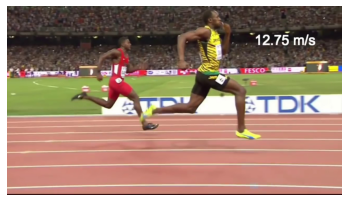

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = np.array(Image.open('images/run.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()


In [3]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
#yolo_model.to(torch.device('cpu'));

Using cache found in /home/namriinz/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv          

In [4]:
yolo_model.to(torch.device('cuda:0'))
print(next(yolo_model.parameters()).is_cuda)
print(next(yolo_model.parameters()).get_device())

True
0


In [5]:
def process_yolo(det_results, score_thr=0.3, cat_id=0):
    bboxes_xyxy = det_results.xyxy
    bboxes_xyxy = bboxes_xyxy[0].detach().cpu().numpy()
    bboxes_xyxy = bboxes_xyxy[(bboxes_xyxy[:, -1] == cat_id) & (bboxes_xyxy[:, -2] > score_thr)]
    
    bboxes_xywh = bboxes_xyxy.copy()

    bboxes_xywh[:, 2] = bboxes_xywh[:, 2]-bboxes_xywh[:, 0]
    bboxes_xywh[:, 3] = bboxes_xywh[:, 3]-bboxes_xywh[:, 1]

    return bboxes_xyxy, bboxes_xywh

In [6]:
det_results = yolo_model(img)

det_results_xyxy, det_results_xywh = process_yolo(det_results)

print(det_results_xyxy)
print(det_results_xywh)

[[        526       12.75         972         509     0.90918           0]
 [     248.88         117         565         468     0.88184           0]]
[[        526       12.75         446      496.25     0.90918           0]
 [     248.88         117      316.12         351     0.88184           0]]


In [7]:
cfg_file = 'configs/pose/top_down/darkpose/coco/res50_coco_256x192_dark.py'
ckpt_file = 'https://download.openmmlab.com/mmpose/top_down/resnet/res50_coco_256x192_dark-43379d20_20200709.pth'

In [8]:
def _box2cs(cfg, box):
    x, y, w, h = box[:4]
    input_size = cfg.data_cfg['image_size']
    aspect_ratio = input_size[0] / input_size[1]
    center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio

    # pixel std is 200.0
    scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)

    scale = scale * 1.25

    return center, scale

In [9]:
class LoadImage:
    def __init__(self, color_type='color', channel_order='rgb'):
        self.color_type = color_type
        self.channel_order = channel_order

    def __call__(self, results):
        results['image_file'] = ''
        if self.color_type == 'color' and self.channel_order == 'rgb':
            img = cv2.cvtColor(results['img_or_path'], cv2.COLOR_BGR2RGB)

        results['img'] = img
        return results

In [10]:
cfg = Config.fromfile(cfg_file)
model = build_posenet(cfg.model)
    
load_checkpoint(model, ckpt_file, map_location='cpu')

model = fuse_conv_bn(model)
model_parallel = MMDataParallel(model, device_ids=[0])

Use load_from_torchvision loader
The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Use load_from_http loader


In [11]:
next(model.parameters()).get_device()

0

In [15]:
def inf_single_pose(model, config, img, bboxes_xywh, bboxes_xyxy):
    device = next(model.parameters()).device

    # build the data pipeline
    channel_order = config.test_pipeline[0].get('channel_order', 'rgb')
    test_pipeline = [LoadImage(channel_order=channel_order)
                     ] + config.test_pipeline[1:]
    test_pipeline = Compose(test_pipeline)

    flip_pairs = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
    
    batch_data = []
    for bbox in bboxes_xywh:
        center, scale = _box2cs(cfg, bbox)

        # prepare data
        data = {
        'img_or_path': img,
        'center': center,
        'scale': scale,
        'bbox_score': bbox[4],
        'bbox_id': 0,
        'dataset': 'TopDownCocoDataset',
        'joints_3d': np.zeros((config.data_cfg.num_joints, 3), dtype=np.float32),
        'joints_3d_visible': np.zeros((config.data_cfg.num_joints, 3), dtype=np.float32),
        'rotation': 0,
        'ann_info': {
            'image_size': config.data_cfg['image_size'],
            'num_joints': config.data_cfg['num_joints'],
            'flip_pairs': flip_pairs
            }
        }

        data = test_pipeline(data)
        batch_data.append(data)

    batch_data = collate(batch_data, samples_per_gpu=1)

       # scatter to specified GPU
    if next(model.parameters()).is_cuda:
        batch_data['img'] = batch_data['img'].to(device)
    batch_data['img_metas'] = [ img_metas[0] for img_metas in batch_data['img_metas'].data]
    
    # forward the model
    with torch.no_grad():
        result = model(img=batch_data['img'], img_metas=batch_data['img_metas'], return_loss=False, return_heatmap=False)
        
    return [{'bbox': bboxes_xyxy[i, :-1], 'keypoints': result['preds'][i]} for i in range(len(result['boxes']))]

In [20]:
s = time.time()
pose_results = inf_single_pose(model, cfg, img, det_results_xywh, det_results_xyxy)
print(1/(time.time()-s))
#print(pose_results)

70.63139282286176


<ipython-input-17-53820f767191>:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show();


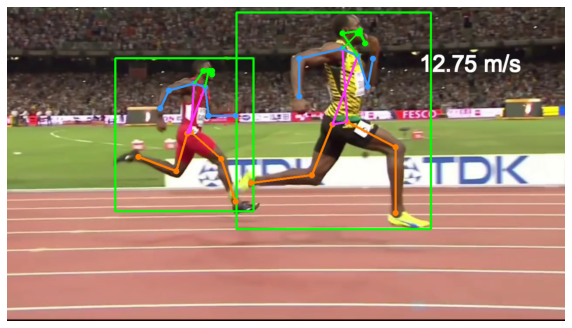

In [17]:
from apis.inference import vis_pose_result
dataset = cfg.data['test']['type']

vis_img = vis_pose_result(
        model,
        img,
        pose_results,
        dataset=dataset,
        kpt_score_thr=0,
        thickness=3, radius = 7,
        show=False )

plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.axis('off')
plt.show();